# General context

The [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) competition aims to enhance automated essay grading systems to support overburdened teachers, especially in underserved communities. It addresses the limitations of previous efforts by using a larger, more diverse dataset to improve scoring accuracy and fairness. Hosted by Vanderbilt University and The Learning Agency Lab, the competition seeks to develop open-source tools that provide timely feedback to students and integrate more effectively into real-world educational settings. This initiative represents a significant advancement in educational technology, promoting equitable access to reliable automated essay scoring.

In this notebook, I conducted exploratory data analysis and developed models using the Deberta V3 architecture ([He et al., 2021](https://arxiv.org/abs/2111.09543)). Additionally, I utilized the Hugging Face `datasets` library in conjunction with PyTorch's `DataLoader` for efficient data handling. I established a training loop using native PyTorch functionalities and modeled the outputs as ordinal values to account for their inherent order.

**Todo: add some result**

# Inclusion and global variables

In [1]:
import os
import math
from dataclasses import dataclass, field
from pathlib import Path
from typing import List, Any
import logging

import settings.settings
import importlib
importlib.reload(settings.settings)

from settings.settings import (
    LOCAL_STR,
    DEBERTA_V3_CKPT,
    DISTILBERT,
    MATPLOTBLUE,
    SEED,
    DEVICE,
    configuration_builder,
)
from settings.function_utils import (
    category_to_ordinal
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import (
    DataLoader,
)

from sklearn.model_selection import train_test_split
import polars as pl

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    DataCollatorWithPadding,
)
import datasets
from datasets import Dataset, DatasetDict
# from peft import LoraConfig 

from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
)

In [2]:
DEBUG = True

## Set and define global configuration

In this section, I set up a configuration builder that utilizes the Python data class `ConfigurationSetting` to enhance the code's flexibility. This approach allows the code to run with specific configurations in dedicated environments. The instance of `ConfigurationSetting` created by the builder is used throughout the code, replacing hardcoded values.

In [3]:
configuration_item = configuration_builder(
    model_ckpt=DISTILBERT,
    plot_color=MATPLOTBLUE,
    seed=SEED,
    device=DEVICE
)

Warnings are suppressed in my local environment, particularly to remove information about my computing system before the code is pushed to GitHub.

In [4]:
if configuration_item.name == LOCAL_STR:
    logging.captureWarnings(True)
    logger: logging.Logger = logging.getLogger("py.warnings")
    logger.addHandler(logging.FileHandler("tmp.log"))

# Load the data

Data comes from the Kaggle competition [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) and can be downloaded from the competition's page.

In [5]:
if not configuration_item.data_path:
    raise ValueError

train_ds = pd.read_csv(
    filepath_or_buffer=configuration_item.data_path / "train.csv"
)


For the sake of speed, I reduced the dataset size in my local environment. However, even with fewer records, fine-tuning DeBERTA on CPU machines remains challenging and significantly slower without GPU access.

In [6]:
# Keep small for local investigation
if (configuration_item.name == LOCAL_STR) | DEBUG:
    train_ds, _ = train_test_split(
        train_ds, 
        test_size=.99, 
        random_state=configuration_item.seed, 
        stratify=train_ds["score"]
    )

# Exploratory Data Analysis

# Data wrangling

## Turn the score label into ordinal

Ordinal regression is used when the dependent variable (the outcome you're trying to predict) holds an intrinsic order, but the distances between the levels are not known. The classic examples include a Likert scale for surveys (e.g., "strongly disagree," "disagree," "neutral," "agree," "strongly agree"), grades (A, B, C, D, F), or in the case at hand, essay scores. The key advantage of ordinal regression is its ability to handle dependent variables that are more nuanced than simple binary outcomes but don’t have the numeric spacing needed for linear regression. For instance, while we know that grade A is higher than grade B, we cannot say that it is exactly two points higher as we might with numerical scores. This is where ordinal regression comes in—it allows the modeling of the rank order of the dependent variable without making assumptions about the value of the intervals between levels. In the context of modeling essay scores, ordinal regression can predict the rank order of the essays' quality. It is particularly apt for this kind of task because it can learn from the order inherent in the scores without assuming equal spacing between score levels. This can result in more accurate models for ordered categorical data, as it respects the nature of the ranking involved. When using ordinal regression, we need to transform the target variable to reflect the ordinal nature. In a standard regression problem, the target is typically a single column of values. In ordinal regression, however, the target is often expanded into a matrix that represents the ranking order. This matrix enables the model to understand and predict not just whether one essay is better than another but the relative ranking across the spectrum of scores. To prepare for ordinal regression, the scores was transformed into an ordinal matrix with a process known as “one-hot encoding” of the ranks. 

In [7]:
train_ds["labels"] = category_to_ordinal(train_ds.score.values).tolist()

In [8]:
display(train_ds.head())

,essay_id,full_text,score,labels
12859,bd3ec7d,While there have been presidents that have run...,6,"[1, 1, 1, 1, 1, 1]"
1744,1b0037e,Is studying Venus a worthy pursuit despite the...,2,"[1, 1, 0, 0, 0, 0]"
5646,545a0f3,Luke Bomberger had a friend who asked him to t...,1,"[1, 0, 0, 0, 0, 0]"
6041,5a7d2db,"In the article ""The Challenge of Exploring Ven...",2,"[1, 1, 0, 0, 0, 0]"
7336,6e0d125,The Face\n\nSome people don't believe the Face...,3,"[1, 1, 1, 0, 0, 0]"


## Create training / validation set

In [9]:
train_set, validation_set = train_test_split(
    train_ds, 
    train_size=.7, 
    random_state=SEED, 
    stratify=train_ds.score
)

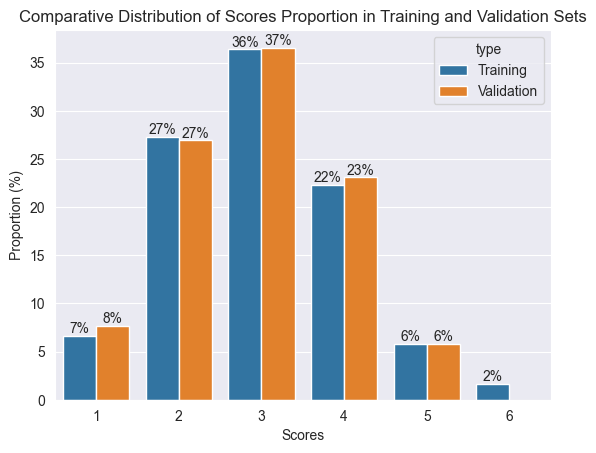

In [10]:
train_set_tmp = train_set.copy()
validation_set_tmp = validation_set.copy()

train_set_tmp["type"] = "Training"
validation_set_tmp["type"] = "Validation"
# ingnore_index force the creation of a new index.
combined_set = pd.concat(
    [train_set_tmp, validation_set_tmp], 
    ignore_index=True
)

proportion = (
    combined_set.groupby("type")["score"]
    .value_counts(normalize=True)
    .reset_index()
)
proportion["proportion"] *=100

ax = sns.barplot(proportion, x="score", y="proportion", hue="type")
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.f%%")
ax.bar_label(ax.containers[1], fontsize=10, fmt="%.f%%")

plt.title("Comparative Distribution of Scores Proportion in Training and Validation Sets")
plt.xlabel("Scores")
plt.ylabel("Proportion (%)")
plt.show()

del(train_set_tmp)
del(validation_set_tmp)
del(proportion)

The provided plot presents a grouped bar chart depicting the distribution of scores within two distinct datasets: Training and Validation. Each score category from 1 to 6 is represented by a pair of bars—one for the Training set (in blue) and one for the Validation set (in orange). The stratification ensures that the proportion of scores in each score category is consistent across both training and validation sets. This consistency is critical when developing a model for ordinal regression, as it allows the model to learn from a training set that mirrors the real-world or expected distribution of scores. Consequently, when the model is validated, the validation set similarly reflects this distribution, allowing for an accurate assessment of the model's performance. From the visual comparison of the bar heights, it is evident that each score's representation in the training set closely matches its representation in the validation set.

In [11]:
data_dict = DatasetDict({
    "training": Dataset.from_pandas(train_set),
    "validation": Dataset.from_pandas(validation_set)
})

## Tokenize the text

Tokenization is a fundamental process in natural language processing (NLP) where text is segmented into smaller units known as tokens. These tokens can be individual words, characters, or subwords. This segmentation is similar to parsing a sentence into its constituent words or breaking a word down into syllables.

In our experiment, we used [DistilBERT model](https://arxiv.org/abs/1910.01108), which has an input size limit of 512 tokens. To prevent errors caused by input sequences that exceed this limit, we set truncation to true for this model.

In [12]:
tokenizer = (AutoTokenizer
             .from_pretrained(configuration_item.model_ckpt)
             )

def tokenize(batch):
    a=1
    return tokenizer(batch["full_text"], padding=True, truncation=True)
encoded_data_dict = data_dict.map(tokenize, batched=True, batch_size=1000)

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

## Compute last hidden state

We transform the token encodings into the last hidden state embeddings using DistilBERT, where each token has a meaningful contextual representation. We extract the last hidden state of the [CLS] token, which specifies the start of the sequence, as a summary of the whole sequence. Ultimately, we use this last hidden state of the [CLS] token as input predictors in a LightGBM model.

In [13]:
model = AutoModel.from_pretrained(
    configuration_item.model_ckpt
).to(configuration_item.torch_device)

def extract_last_hidden_state(batch, model, tokenizer):
    mdl_item = {k: v.to(configuration_item.torch_device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**mdl_item).last_hidden_state
    return {"last_hidden_state": last_hidden_state[:, 0].cpu().numpy()}

encoded_data_dict.set_format(type="pt", columns=["input_ids", "attention_mask", "score"])

hidden_data_dict = encoded_data_dict.map(extract_last_hidden_state, 
                                       fn_kwargs={"model": model, "tokenizer": tokenizer}, 
                                       batched=True, batch_size=2)

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

# Modeling using LightGBM

In [23]:
from sklearn.model_selection import KFold, cross_validate
from optuna.samplers import TPESampler
import optuna
from optuna.integration.lightgbm import cv
from lightgbm import Dataset as LGBMDataSet, early_stopping, cv, LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
    f1_score,
    recall_score,
)

## Parameters

### Objectives parameters

### Metric parameters

In [15]:
def wrap_param(trial=None, refit=False):
    params = {
        "task": "train",
        "objective": "multiclass",
        "num_class": configuration_item.num_labels,
        "is_unbalanced": True,
        "boosting": "gbdt",
        "device_type": configuration_item.device,
        "num_thread": configuration_item.n_worker,
        "tree_learner": "feature_parallel", # (https://lightgbm.readthedocs.io/en/stable/Parallel-Learning-Guide.html)
        "seed": configuration_item.seed, # Overal seed.
        "verbosity": -1,
        "learning_rate": 1e-1,
        "metric": ["multi_logloss", "multi_error", "auc_mu", ],
        "first_metric_only": True,
        "data_sample_strategy": "goss", # Gradient-Based One-Side Sampling --> Focusing on higher errored records
        "boost_from_average": True,
        "extra_trees": True, # EXTremely RAndomize trees: speed up training, decrease training overfitting.
        "is_provide_training_metric": True,
        "force_col_wise": True, # Force because large number of columns. Forcing reduce overhead due to testing the best data representation.
        
    }
    if trial:
        params |= {
            "feature_fraction": trial.suggest_float("feature_fraction", .4, 1.0),
            "sigmoid": trial.suggest_float("sigmoid", 10e-4, 5.0),
            "num_leaves": trial.suggest_int("num_leaves", 8, 256),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 10.0),
            "min_sum_hessian": trial.suggest_int("min_sum_hessian", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", .4, 1.0),
            "sigmoid": trial.suggest_float("sigmoid", 10e-4, 8),
        }
    elif refit:
        params |= {"task": "refit"}
    else:
        params |= {"task": "predict"}
    
    return params

In [16]:
def objective(X, y, get_params):
    def run(trial):
        training_set = LGBMDataSet(data=X, label=y, free_raw_data=False)
        params = get_params(trial)
        
        callbacks = [ early_stopping(stopping_rounds=200, first_metric_only=True, verbose=True) ]
        reg_cv = cv(
            params=params,
            train_set=training_set,
            num_boost_round=1000,  # == num_iterations
            nfold=10,
            stratified=True,
            callbacks=callbacks,
            seed=configuration_item.seed,
            return_cvbooster=True,
        )
        trial.set_user_attr("num_iterations", reg_cv.get("cvbooster").best_iteration)
        return np.min(
            np.add(
                reg_cv.get("valid multi_logloss-mean"),
                reg_cv.get("valid multi_logloss-stdv")
            )
        )
    return run

In [17]:
def lgbm_cv(X, y, n_trials=10, study_name="default", get_param=None):
    study = optuna.create_study(
        study_name=study_name,
        sampler=TPESampler(n_startup_trials=7, multivariate=True),
    )
    study.optimize(
        func=objective(X, y, get_param),
        n_trials=10,
        show_progress_bar=True,
    )
    return study

In [18]:
hidden_data_dict.set_format(type="numpy")
n_dim = hidden_data_dict["training"]["last_hidden_state"].shape[1]
col_names = [f"V{i + 1:03d}" for i in range(n_dim)]
X_training = pd.DataFrame(hidden_data_dict["training"]["last_hidden_state"], columns=col_names)
y_training = pd.DataFrame(hidden_data_dict["training"]["score"], columns=["score"])
X_validation = pd.DataFrame(hidden_data_dict["validation"]["last_hidden_state"], columns=col_names)
y_validation = pd.DataFrame(hidden_data_dict["validation"]["score"], columns=["score"])
y_training["score"] = y_training.score - 1
hidden_data_dict.reset_format()

In [19]:
study = lgbm_cv(X_training, y_training, get_param=wrap_param, n_trials=1)

[I 2024-05-25 06:36:43,308] A new study created in memory with name: default


  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid multi_logloss: 1.48327 + 0.125027	cv_agg's valid multi_error: 0.635897 + 0.043552	cv_agg's valid auc_mu: nan + nan
Evaluated only: multi_logloss
[I 2024-05-25 06:36:45,138] Trial 0 finished with value: 1.6083019669045713 and parameters: {'feature_fraction': 0.6477809940331694, 'sigmoid': 0.9418883145443464, 'num_leaves': 17, 'lambda_l2': 8.685171858288737, 'min_sum_hessian': 41, 'bagging_fraction': 0.6967001641152247}. Best is trial 0 with value: 1.6083019669045713.
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid multi_logloss: 1.48327 + 0.125027	cv_agg's valid multi_error: 0.635897 + 0.043552	cv_agg's valid auc_mu: nan + nan
Evaluated only: multi_logloss
[I 2024-05-25 06:36:47,519] Trial 1 finished with value: 1.6083019669045713 and parameters: {'feature_fraction': 0.9188091450580556, 'sigmoid': 4.905463

In [20]:
def get_performance_metrics(truth, estimate):
    return ({
        "Accuracy": accuracy_score(truth, estimate),
        "Balanced Accuracy": balanced_accuracy_score(truth, estimate),
        "Weighted F1": f1_score(truth, estimate, average="weighted"),
        "Weighted Recall": recall_score(truth, estimate, average="weighted"),
        "QWK": cohen_kappa_score(truth, estimate, weights="quadratic"),
    })

In [21]:
fixed_params = wrap_param(refit=True)
hyperparametrized_params = study.best_trial.params
n_iteration = study.best_trial.user_attrs
params = fixed_params | hyperparametrized_params | n_iteration

model = LGBMClassifier(**params)
model.fit(X_training, np.ravel(y_training["score"]))

y_validation_pred = model.predict(X_validation)


In [25]:
performances = get_performance_metrics(truth=y_validation, estimate=y_validation_pred)
performances
# display(pd.DataFrame.from_dict(performances))

{'Accuracy': 0.2692307692307692,
 'Balanced Accuracy': 0.2,
 'Weighted F1': 0.11421911421911422,
 'Weighted Recall': 0.2692307692307692,
 'QWK': 0.0}